In [14]:
import os
# set mujoco gl to egl
os.environ['MUJOCO_GL']='egl'

from __future__ import annotations

import base64
from pathlib import Path
import mujoco
import mujoco.rollout as rollout
import numpy as np
from absl import logging
from mujoco import sysid
import mediapy as media
from matplotlib import pyplot as plt
import pickle


logging.set_verbosity("INFO")

MJCF_PATH=Path("assets") / "leap_hand" / "mjcf" / "right_hand.xml"
OUTPUT_DIR=Path("outputs/real_results")

from IPython.display import IFrame

def display_report(report):
    html_b64 = base64.b64encode(report.build().encode()).decode()
    return IFrame(src=f"data:text/html;base64,{html_b64}", width="100%", height=800)

In [15]:
print(f"Loading model from {str(MJCF_PATH)}...")

spec = mujoco.MjSpec.from_file(str(MJCF_PATH))
model = spec.compile()
data = mujoco.MjData(model)

Loading model from assets/leap_hand/mjcf/right_hand.xml...


In [ ]:
# load the data
joint_name = "if_mcp"
path = f"outputs/traj/{joint_name}_trajectory.pkl"
with open(path, "rb") as f:
    traj_data = pickle.load(f)

data_t = traj_data["t"]
data_ctrl = traj_data["ctrl"]
data_sensor_time = traj_data["sensor_time"]
data_sensor = traj_data["sensor"]
data_init_qpos = traj_data["init_qpos"]
joints_to_sysid = traj_data["sys_id_joints"]
spec_timestep = model.opt.timestep
traj_timestep = traj_data["timestep"]
print(f"Loaded {path} with {len(data_t)} timesteps, timestep={model.opt.timestep}")


Loaded outputs/traj/if_mcp_trajectory.pkl with 500 timesteps, timestep=0.002


In [4]:
joint_names = list(data_sensor.keys())
print("joint_names:", joint_names)
num_joints = len(joint_names)

# set init_qpos
# init_qpos = np.zeros(num_joints)
for joint_name in joint_names:
    joint_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_JOINT, joint_name
    )
    if joint_id == -1:
        raise ValueError(f"Joint {joint_name} not found in model")
    qpos_adr = model.jnt_qposadr[joint_id]
    data.qpos[qpos_adr] = data_init_qpos[joint_name]

# set sensor
sensor = np.zeros((len(data_sensor_time), num_joints))
for joint_name in joint_names:
    sensor_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_SENSOR, f"{joint_name}_sensor"
    )
    if sensor_id == -1:
        raise ValueError(f"Sensor {joint_name}_sensor not found in model")
    sensor_adr = model.sensor_adr[sensor_id]
    sensor[:, sensor_adr] = data_sensor[joint_name]
# check for bad values in sensor
if np.any(np.isnan(sensor)) or np.any(np.isinf(sensor)):
    raise ValueError("Sensor data contains NaN or Inf values")

# set ctrl
ctrl = np.zeros((len(data_t), num_joints))
for joint_name in joint_names:
    ctrl_id = mujoco.mj_name2id(
        model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"{joint_name}_act"
    )
    if ctrl_id == -1:
        raise ValueError(f"Actuator {joint_name}_actuator not found in model")
    if joint_name in data_ctrl:
        ctrl[:, ctrl_id] = data_ctrl[joint_name]
    else:
        ctrl[:, ctrl_id] = data_init_qpos[joint_name]
# check for bad values in ctrl
if np.any(np.isnan(ctrl)) or np.any(np.isinf(ctrl)):
    raise ValueError("Control data contains NaN or Inf values")

# set qvel to 0
data.qvel[:] = 0.0

t = data_t
times = data_sensor_time
# check that t and times are strictly increasing
assert np.all(np.diff(t) > 0), "t is not strictly increasing"
assert np.all(np.diff(times) > 0), "times is not strictly increasing"

mujoco.mj_forward(model, data)

joint_names: ['if_mcp', 'if_rot', 'if_pip', 'if_dip', 'mf_mcp', 'mf_rot', 'mf_pip', 'mf_dip', 'rf_mcp', 'rf_rot', 'rf_pip', 'rf_dip', 'th_cmc', 'th_axl', 'th_mcp', 'th_ipl']


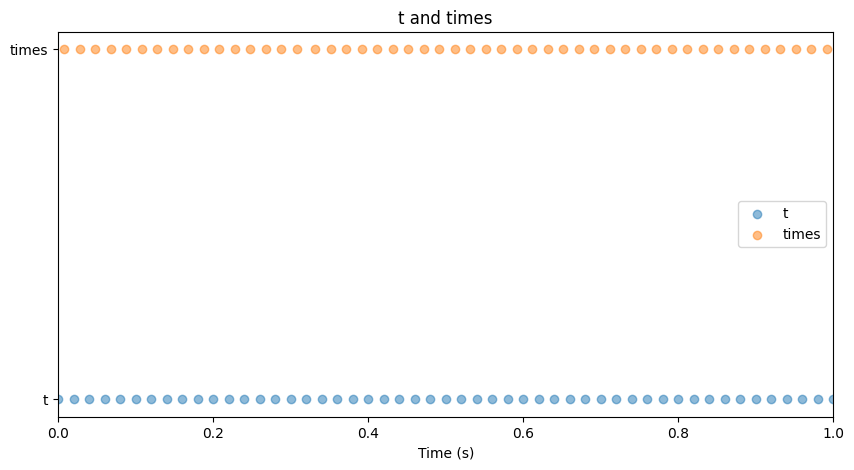

In [5]:
# plot t and times to check they are correct (perhaps scatter plot)
# just plot like first 20 values to check they are correct
plt.figure(figsize=(10, 5))
plt.scatter(t, np.zeros_like(t), label="t", alpha=0.5)
plt.scatter(times, np.ones_like(times), label="times", alpha=0.5)
plt.legend()
plt.title("t and times")
plt.xlabel("Time (s)")
plt.yticks([0, 1], ["t", "times"])
# set xlim to show to 1 second
plt.xlim(0, 1)
plt.show()

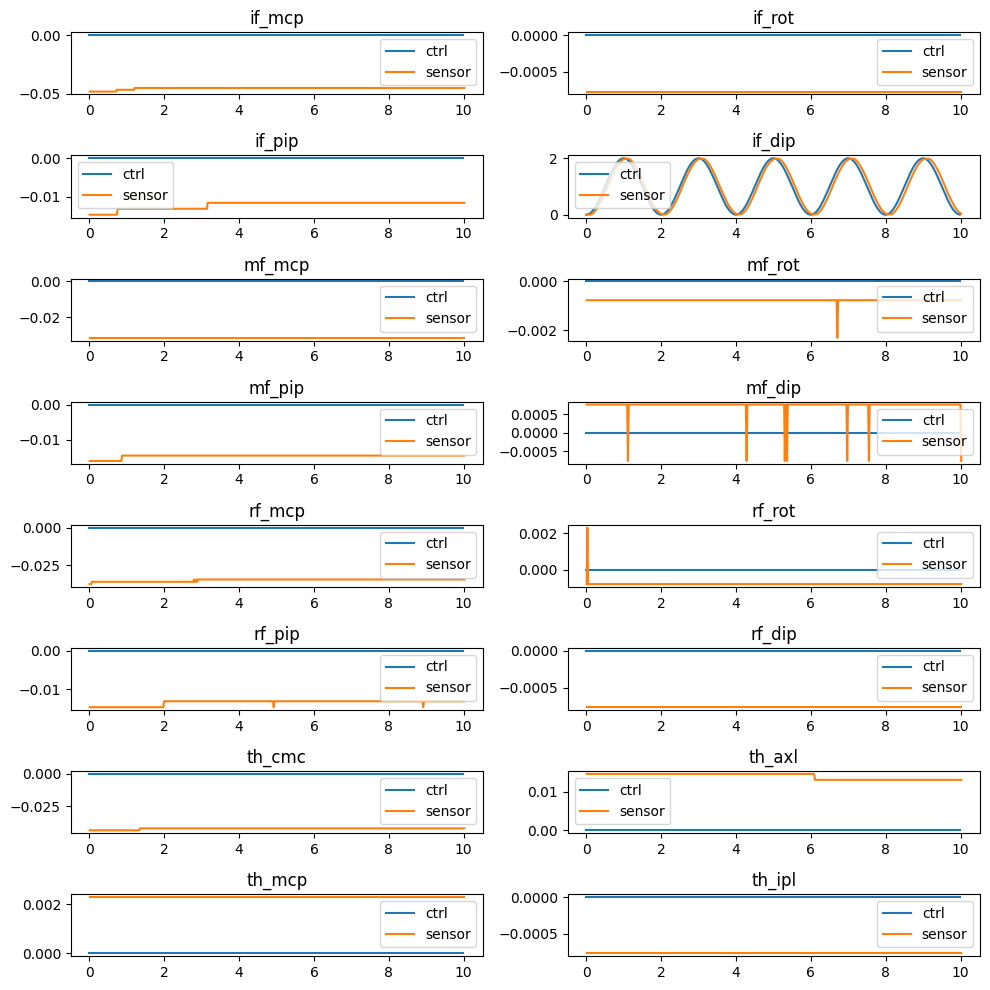

In [10]:
initial_state = sysid.create_initial_state(
    model, data.qpos, data.qvel, data.act
)
# Use zero-order hold so control is held between trajectory samples.
control_ts = sysid.TimeSeries(t, ctrl).resample(
    target_dt=model.opt.timestep, method="zoh"
)
sensor_ts = sysid.TimeSeries.from_names(times, sensor, model).resample(
    target_dt=model.opt.timestep, method="linear"
)

# plot ctrl and sensor , each joint is a subplot and plot ctrl and sensor in the same subplot
fig, axes = plt.subplots(num_joints // 2,  2, figsize=(10, 10))
for i, joint_name in enumerate(joint_names):
    row = i // 2
    col = i % 2
    axes[row, col].plot(t, ctrl[:, i], label="ctrl")
    axes[row, col].plot(times, sensor[:, i], label="sensor")
    axes[row, col].set_title(joint_name)
    axes[row, col].legend()
plt.tight_layout()
plt.show()

state, _ = rollout.rollout(model, data, initial_state, control_ts.data)
state = np.squeeze(state, axis=0)
frames = sysid.render_rollout(
    model, data, state[None], framerate=30, height=400, width=560
)
media.show_video(frames, fps=30)

In [11]:
INIT_KP = 3.0
INIT_KV = -0.03

def make_armature_modifier(joint_name):
    """Create a modifier that sets armature on a specific joint."""
    def modifier(spec, param):
        spec.joint(joint_name).armature = param.value[0]
    return modifier

def make_joint_damping_modifier(joint_name):
    """Create a modifier that sets damping on a specific joint."""
    def modifier(spec, param):
        spec.joint(joint_name).damping = param.value[0]
    return modifier

def make_actuator_kp_modifier(actuator_name):
    """Create a modifier that sets gain on a specific actuator."""
    def modifier(spec, param):
        # print(f"Setting {actuator_name} kp to {param.value[0]}, originally {spec.actuator(actuator_name).gainprm[0]}")
        spec.actuator(actuator_name).gainprm[0] = param.value[0]
    return modifier

def make_actuator_kv_modifier(actuator_name):
    """Create a modifier that sets gain on a specific actuator."""
    def modifier(spec, param):
        # print(f"Setting {actuator_name} kv to {param.value[0]}, originally {spec.actuator(actuator_name).biasprm[2]}")
        spec.actuator(actuator_name).biasprm[2] = param.value[0]
    return modifier

params = sysid.ParameterDict()
for name in joints_to_sysid:
    act_name = f"{name}_act"
    # get actuator actual kp and kv
    act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, act_name)
    true_kp = model.actuator_gainprm[act_id, 0]
    true_kv = model.actuator_biasprm[act_id, 2]
    params.add(sysid.Parameter(
        f"{name}_kp",
        nominal=true_kp,
        min_value=0.0,
        max_value=5.0,
        modifier=make_actuator_kp_modifier(act_name),
    ))
    params[f"{name}_kp"].value[:] = INIT_KP
    params.add(sysid.Parameter(
        f"{name}_kv",
        nominal=true_kv,
        min_value=-1.0,
        max_value=0.0,
        modifier=make_actuator_kv_modifier(act_name),
    ))
    params[f"{name}_kv"].value[:] = INIT_KV


In [12]:
#@title { vertical-output: true}
ms = sysid.ModelSequences(
    "leap_hand", spec, "sinusoidal", initial_state, control_ts, sensor_ts,
 )
residual_fn = sysid.build_residual_fn(models_sequences=[ms])
opt_params, opt_result = sysid.optimize(
    initial_params=params,
    residual_fn=residual_fn,
    optimizer="mujoco",
)

iter: 0    y: 16.13      log10mu: -inf  ratio: 1.7      dx: 0.27     reduction: 0.022  
iter: 1    y: 16.11      log10mu: -inf  ratio: 0.73     dx: 0.17     reduction: 0.02   
iter: 2    y: 16.09      log10mu: -inf  ratio: 0.29     dx: 0.06     reduction: 0.00053
iter: 3    y: 16.09      log10mu: -inf  ratio: 0.62     dx: 0.029    reduction: 0.00037
iter: 4    y: 16.09      log10mu: -inf  ratio: 0.91     dx: 0.019    reduction: 8.1e-05
iter: 5    y: 16.09      log10mu: -inf  ratio: 1.3      dx: 0.00086  reduction: 2.1e-07
iter: 6    y: 16.09      log10mu: -inf  ratio: 0.38     dx: 0.00021  reduction: 1.1e-08
iter: 7    y: 16.09      log10mu: -inf  ratio: 0.73     dx: 0.00065  reduction: 2e-07  
iter: 8    y: 16.09      log10mu: -1.7  ratio: 0.026    dx: 8e-05    reduction: 1.1e-10
iter: 9    y: 16.09      log10mu: -0.2  ratio: 0.032    dx: 0.00038  reduction: 5.9e-09
iter: 10   y: 16.09      log10mu: -0.1  ratio: 0.58     dx: 0.00015  reduction: 1.9e-08
iter: 11   y: 16.09      log10mu

INFO:absl:
+----------------------+-----------+-----------+--------------+-------------+-------------+-----------+-----------+-----------+-----------+
| Parameter            | Initial   | Nominal   | Identified   | Lower       | Upper       | Abs Err   | Abs Del   | Rel Err   | Rel Del   |
+======================+===========+===========+==============+=============+=============+===========+===========+===========+===========+
| if_dip_kp            |  3.0000   |  3.0000   |  2.6650      |  0.0000e+00 |  5.0000     |  0.3350   |  0.3350   | 11.2%     | 11.2%     |
| if_dip_kv            | -0.0300   | -0.0300   | -0.1907      | -1.0000     |  0.0000e+00 |  0.1607   |  0.1607   | 535.7%    | 535.7%    |
+----------------------+-----------+-----------+--------------+-------------+-------------+-----------+-----------+-----------+-----------+
RMSE: 0.2627
RMS Delta: 0.2627


iter: 21   y: 16.09      log10mu:  6.4  ratio: 56       dx: 5e-12    reduction: 3.6e-15
Terminated after 21 iterations: norm(dx) < tol. y: 16.09, Residual evals: 205
total time 28.8s of which residual 99.9%


In [13]:
report = sysid.default_report(
    models_sequences=[ms],
    initial_params=params,
    opt_params=opt_params,
    residual_fn=residual_fn,
    opt_result=opt_result,
    title="Leap Hand Identification",
    save_path=OUTPUT_DIR,
)
# display_report(report)

In [ ]:
INIT_KP = 3.0
INIT_KV = -0.03

def run_sysid(traj_data_path, save_dir):
    print(f"Loading model from {str(MJCF_PATH)}...")
    spec = mujoco.MjSpec.from_file(str(MJCF_PATH))
    model = spec.compile()
    data = mujoco.MjData(model)

    #------------
    # load the data
    #-------------
    with open(traj_data_path, "rb") as f:
        traj_data = pickle.load(f)
    data_t = traj_data["t"]
    data_ctrl = traj_data["ctrl"]
    data_sensor_time = traj_data["sensor_time"]
    data_sensor = traj_data["sensor"]
    data_init_qpos = traj_data["init_qpos"]
    joints_to_sysid = traj_data["sys_id_joints"]
    spec_timestep = model.opt.timestep
    traj_timestep = traj_data["timestep"]
    n_step = round(traj_timestep / spec_timestep)
    if spec_timestep != traj_timestep:
        logging.warning(
            f"Model timestep {spec_timestep} does not match trajectory timestep {traj_timestep}. "
            f"Using n_step={n_step} to subsample the trajectory for system identification."
        )
    print(f"Loaded {traj_data_path} with {len(data_t)} timesteps, timestep={model.opt.timestep}")

    # -------------------
    # set correct indexing
    # ---------------------------
    joint_names = list(data_sensor.keys())
    num_joints = len(joint_names)
    # set init_qpos
    for joint_name in joint_names:
        joint_id = mujoco.mj_name2id(
            model, mujoco.mjtObj.mjOBJ_JOINT, joint_name
        )
        if joint_id == -1:
            raise ValueError(f"Joint {joint_name} not found in model")
        qpos_adr = model.jnt_qposadr[joint_id]
        data.qpos[qpos_adr] = data_init_qpos[joint_name]
    # set sensor
    sensor = np.zeros((len(data_sensor_time), num_joints))
    for joint_name in joint_names:
        sensor_id = mujoco.mj_name2id(
            model, mujoco.mjtObj.mjOBJ_SENSOR, f"{joint_name}_sensor"
        )
        if sensor_id == -1:
            raise ValueError(f"Sensor {joint_name}_sensor not found in model")
        sensor_adr = model.sensor_adr[sensor_id]
        sensor[:, sensor_adr] = data_sensor[joint_name]
    # set ctrl
    ctrl = np.zeros((len(data_t), num_joints))
    for joint_name in joint_names:
        ctrl_id = mujoco.mj_name2id(
            model, mujoco.mjtObj.mjOBJ_ACTUATOR, f"{joint_name}_act"
        )
        if ctrl_id == -1:
            raise ValueError(f"Actuator {joint_name}_actuator not found in model")
        # TODO couldn't find right act id?
        if joint_name in data_ctrl:
            ctrl[:, ctrl_id] = data_ctrl[joint_name]
        else:
            ctrl[:, ctrl_id] = data_init_qpos[joint_name]
    # set qvel to 0
    data.qvel[:] = 0.0
    t = data_t
    times = data_sensor_time
    mujoco.mj_forward(model, data)
    initial_state = sysid.create_initial_state(
        model, data.qpos, data.qvel, data.act
    )
    # Use zero-order hold so control is held between trajectory samples.
    control_ts = sysid.TimeSeries(t, ctrl).resample(
        target_dt=model.opt.timestep, method="zoh"
    )
    sensor_ts = sysid.TimeSeries.from_names(times, sensor, model)

    # -------------------
    # define modifiers
    # -------------------
    def make_armature_modifier(joint_name):
        """Create a modifier that sets armature on a specific joint."""
        def modifier(spec, param):
            spec.joint(joint_name).armature = param.value[0]
        return modifier

    def make_joint_damping_modifier(joint_name):
        """Create a modifier that sets damping on a specific joint."""
        def modifier(spec, param):
            spec.joint(joint_name).damping = param.value[0]
        return modifier

    def make_actuator_kp_modifier(actuator_name):
        """Create a modifier that sets gain on a specific actuator."""
        def modifier(spec, param):
            # print(f"Setting {actuator_name} kp to {param.value[0]}, originally {spec.actuator(actuator_name).gainprm[0]}")
            spec.actuator(actuator_name).gainprm[0] = param.value[0]
        return modifier

    def make_actuator_kv_modifier(actuator_name):
        """Create a modifier that sets gain on a specific actuator."""
        def modifier(spec, param):
            # print(f"Setting {actuator_name} kv to {param.value[0]}, originally {spec.actuator(actuator_name).biasprm[2]}")
            spec.actuator(actuator_name).biasprm[2] = param.value[0]
        return modifier

    params = sysid.ParameterDict()
    for name in joints_to_sysid:
        act_name = f"{name}_act"
        # get actuator actual kp and kv
        act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, act_name)
        true_kp = model.actuator_gainprm[act_id, 0]
        true_kv = model.actuator_biasprm[act_id, 2]
        params.add(sysid.Parameter(
            f"{name}_kp",
            nominal=true_kp,
            min_value=0.0,
            max_value=5.0,
            modifier=make_actuator_kp_modifier(act_name),
        ))
        params[f"{name}_kp"].value[:] = INIT_KP
        params.add(sysid.Parameter(
            f"{name}_kv",
            nominal=true_kv,
            min_value=-1.0,
            max_value=0.0,
            modifier=make_actuator_kv_modifier(act_name),
        ))
        params[f"{name}_kv"].value[:] = INIT_KV

    # ---------------
    # run optimization
    # ----------------
    ms = sysid.ModelSequences(
        "leap_hand", spec, "sinusoidal", initial_state, control_ts, sensor_ts,
    )
    residual_fn = sysid.build_residual_fn(
        models_sequences=[ms],
        modify_residual=modify_residual_zoh,
        resample_true=False,
    )
    opt_params, opt_result = sysid.optimize(
        initial_params=params,
        residual_fn=residual_fn,
        optimizer="mujoco",
    )
    report = sysid.default_report(
        models_sequences=[ms],
        initial_params=params,
        opt_params=opt_params,
        residual_fn=residual_fn,
        opt_result=opt_result,
        title="Leap Hand Identification",
        save_path=save_dir,
    )





In [27]:
traj_files = Path("outputs/traj").glob("*_trajectory.pkl")
for traj_file in traj_files:
    save_dir = OUTPUT_DIR / traj_file.stem
    run_sysid(traj_file, save_dir)

Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/mf_pip_trajectory.pkl with 500 timesteps, timestep=0.002
iter: 0    y: 27.91      log10mu: -inf  ratio: 1        dx: 1.9      reduction: 1.9    
iter: 1    y: 25.99      log10mu: -inf  ratio: 1.3      dx: 0.11     reduction: 0.087  
iter: 2    y: 25.9       log10mu: -inf  ratio: 0.56     dx: 0.13     reduction: 0.032  
iter: 3    y: 25.87      log10mu: -inf  ratio: 1.7      dx: 0.022    reduction: 0.012  
iter: 4    y: 25.86      log10mu: -inf  ratio: 0.71     dx: 0.036    reduction: 0.014  
iter: 5    y: 25.84      log10mu:  0.4  ratio: 0.29     dx: 0.018    reduction: 0.0021 
iter: 6    y: 25.84      log10mu:  0.8  ratio: 0.17     dx: 0.022    reduction: 0.0028 
iter: 7    y: 25.84      log10mu:  2.7  ratio: 86       dx: 0.00019  reduction: 0.0017 
iter: 8    y: 25.83      log10mu:  4.5  ratio: 1        dx: 2.3e-05  reduction: 1.7e-05
iter: 9    y: 25.83      log10mu:  5.7  ratio: 1        dx: 1.5e-06  red

INFO:absl:
+----------------------+-----------+-----------+--------------+-------------+-------------+-----------+-----------+-----------+-----------+
| Parameter            | Initial   | Nominal   | Identified   | Lower       | Upper       | Abs Err   | Abs Del   | Rel Err   | Rel Del   |
+======================+===========+===========+==============+=============+=============+===========+===========+===========+===========+
| mf_pip_kp            |  3.0000   |  3.0000   |  5.0000      |  0.0000e+00 |  5.0000     |  2.0000   |  2.0000   | 66.7%     | 66.7%     |
| mf_pip_kv            | -0.0300   | -0.0300   | -0.4060      | -1.0000     |  0.0000e+00 |  0.3760   |  0.3760   | 1253.4%   | 1253.4%   |
+----------------------+-----------+-----------+--------------+-------------+-------------+-----------+-----------+-----------+-----------+
RMSE: 1.439
RMS Delta: 1.439


Terminated after 11 iterations: insufficient reduction. y: 25.83, Residual evals: 183
total time 25.4s of which residual 100.0%


Loading model from assets/leap_hand/mjcf/right_hand.xml...
Loaded outputs/traj/if_dip_trajectory.pkl with 500 timesteps, timestep=0.002
iter: 0    y: 15.95      log10mu: -inf  ratio: 0.94     dx: 0.32     reduction: 0.081  
iter: 1    y: 15.87      log10mu:  0.7  ratio: 0.015    dx: 0.017    reduction: 2.7e-05
iter: 2    y: 15.87      log10mu:  0.8  ratio: 0.97     dx: 0.0068   reduction: 0.00034
iter: 3    y: 15.87      log10mu:  0.7  ratio: 0.58     dx: 0.0053   reduction: 0.0001 
iter: 4    y: 15.87      log10mu:  1.4  ratio: 0.092    dx: 0.0021   reduction: 1.1e-05
iter: 5    y: 15.87      log10mu:  1.5  ratio: 0.99     dx: 0.00091  reduction: 2.7e-05
iter: 6    y: 15.87      log10mu:  1.8  ratio: 0.095    dx: 0.00044  reduction: 1.2e-06
iter: 7    y: 15.87      log10mu:  1.9  ratio: 0.59     dx: 0.00027  reduction: 3.6e-06
iter: 8    y: 15.87      log10mu:  2.4  ratio: 0.028    dx: 0.00011  reduction: 8.8e-08
iter: 9    y: 15.87      log10mu:  2.5  ratio: 0.74     dx: 6.9e-05  red

KeyboardInterrupt: 